# Finding star positions 

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import rawpy
from astropy.table import Table
from astropy.io import fits
import photutils

Populating the interactive namespace from numpy and matplotlib


## Read and normalize image

Start with last image in sequence. The last images have the highest exposure setting. This should make it easier for the star-finding algorithms to work. It also places every other image in the sequence on the same side of the temporal sequence (shouldn't be a limiting factor though).

In [2]:
# read image file
path = '../astrophotography_data/MilkyWayPrettyBoy/'
list_p = glob.glob(os.path.join(path,'12800/light/*.ARW'))
fname = list_p[-1] # last

raw = rawpy.imread(fname)

In [3]:
# debayer
rgb = raw.postprocess(
    demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
    output_bps=16,
    gamma=(1,1), 
    use_camera_wb=False,
    use_auto_wb=False,
    no_auto_bright=True, 
    no_auto_scale=True,
    output_color=rawpy.ColorSpace.raw
)

red = rgb[::,::,0]
green = rgb[::,::,1]
blue = rgb[::,::,2]

Flat image was created by notebook Flat_analysis_1.ipynb

In [4]:
# read and normalize flat image (use this specific flat image)
flat_name = os.path.join(path, '12800/light/flat_raw_2.fits') 
hdul = fits.open(flat_name)
flat_red = hdul[1].data
flat_green = hdul[2].data
flat_blue = hdul[3].data

flat_red /= np.max(flat_red) 
flat_green /= np.max(flat_green)
flat_blue /= np.max(flat_blue) 

In [5]:
# normalize bands
norm_red = red / flat_red
norm_green = green / flat_green
norm_blue = blue / flat_blue

<IPython.core.display.Javascript object>


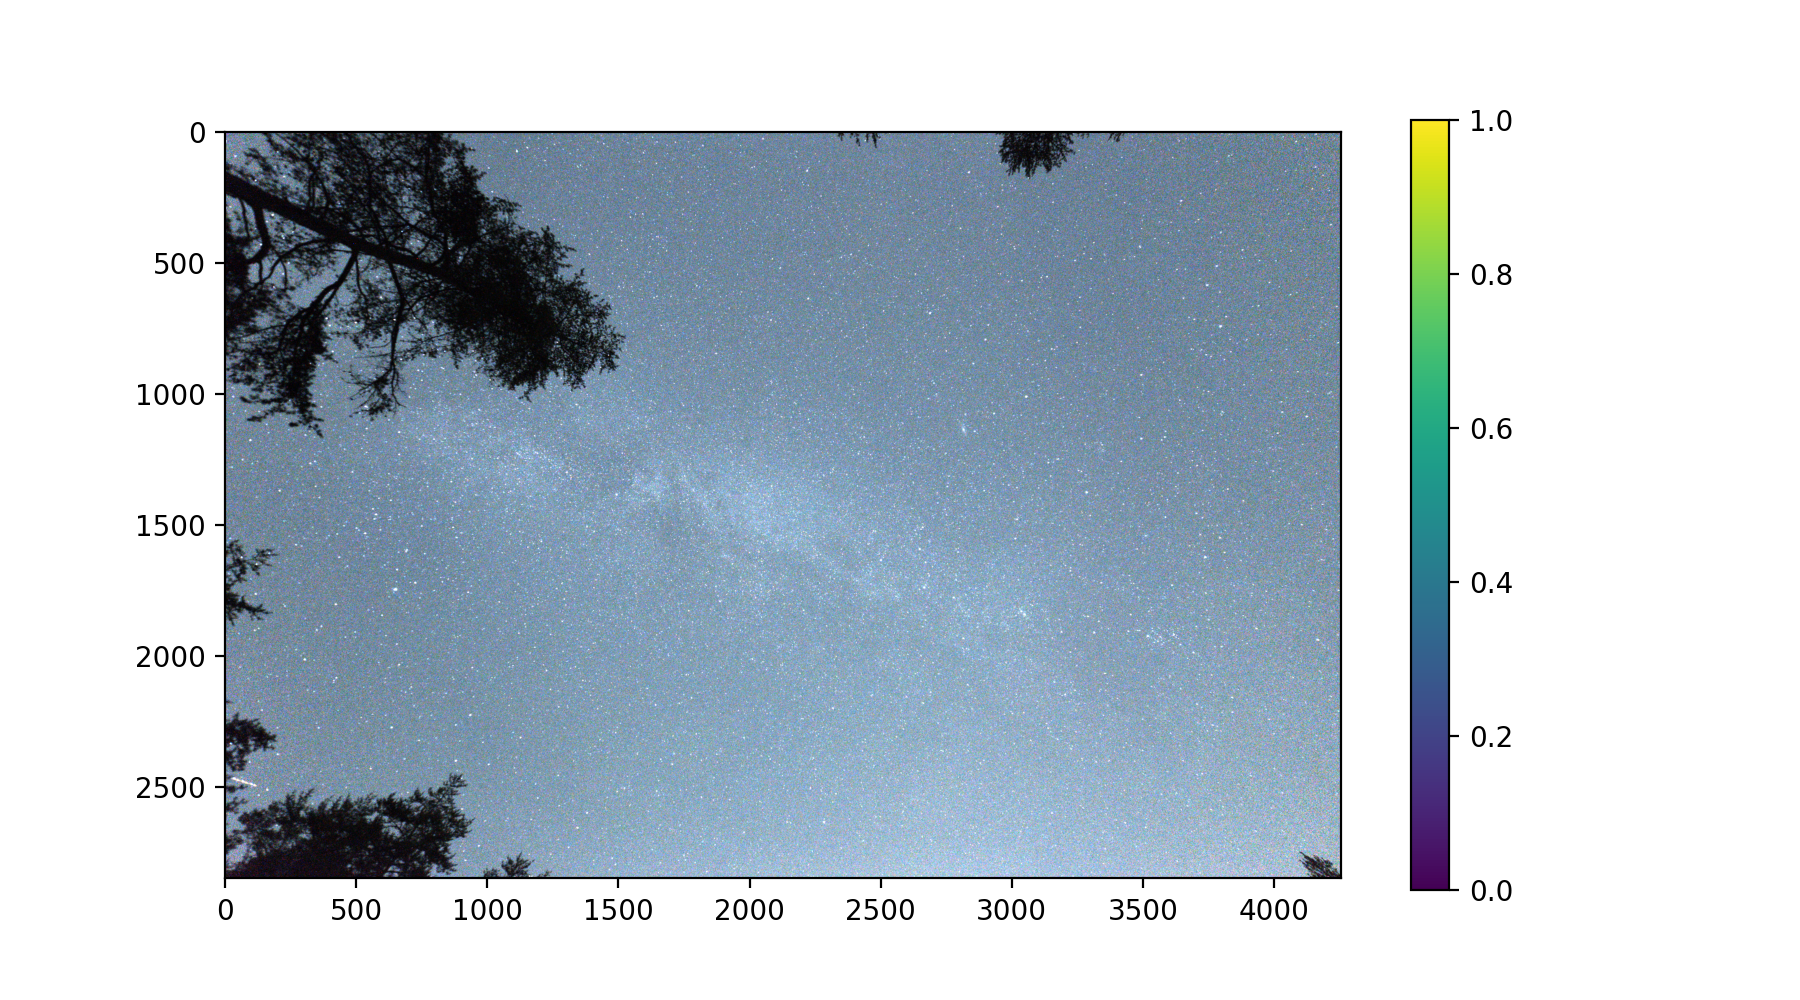

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
# Check result by reassembling bands into RGB image. Scale to fit matplotlib limits.
norm_rgb_scaled = np.zeros(shape=(red.shape[0],red.shape[1],3))

norm_factor = max(np.max(norm_red), np.max(norm_green), np.max(norm_blue))

norm_rgb_scaled[::,::,0] = norm_red / norm_factor * 60 * 1.2
norm_rgb_scaled[::,::,1] = norm_green / norm_factor * 30 * 1.4
norm_rgb_scaled[::,::,2] = norm_blue / norm_factor * 60 * 1.3

plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled)
plt.colorbar()

<IPython.core.display.Javascript object>


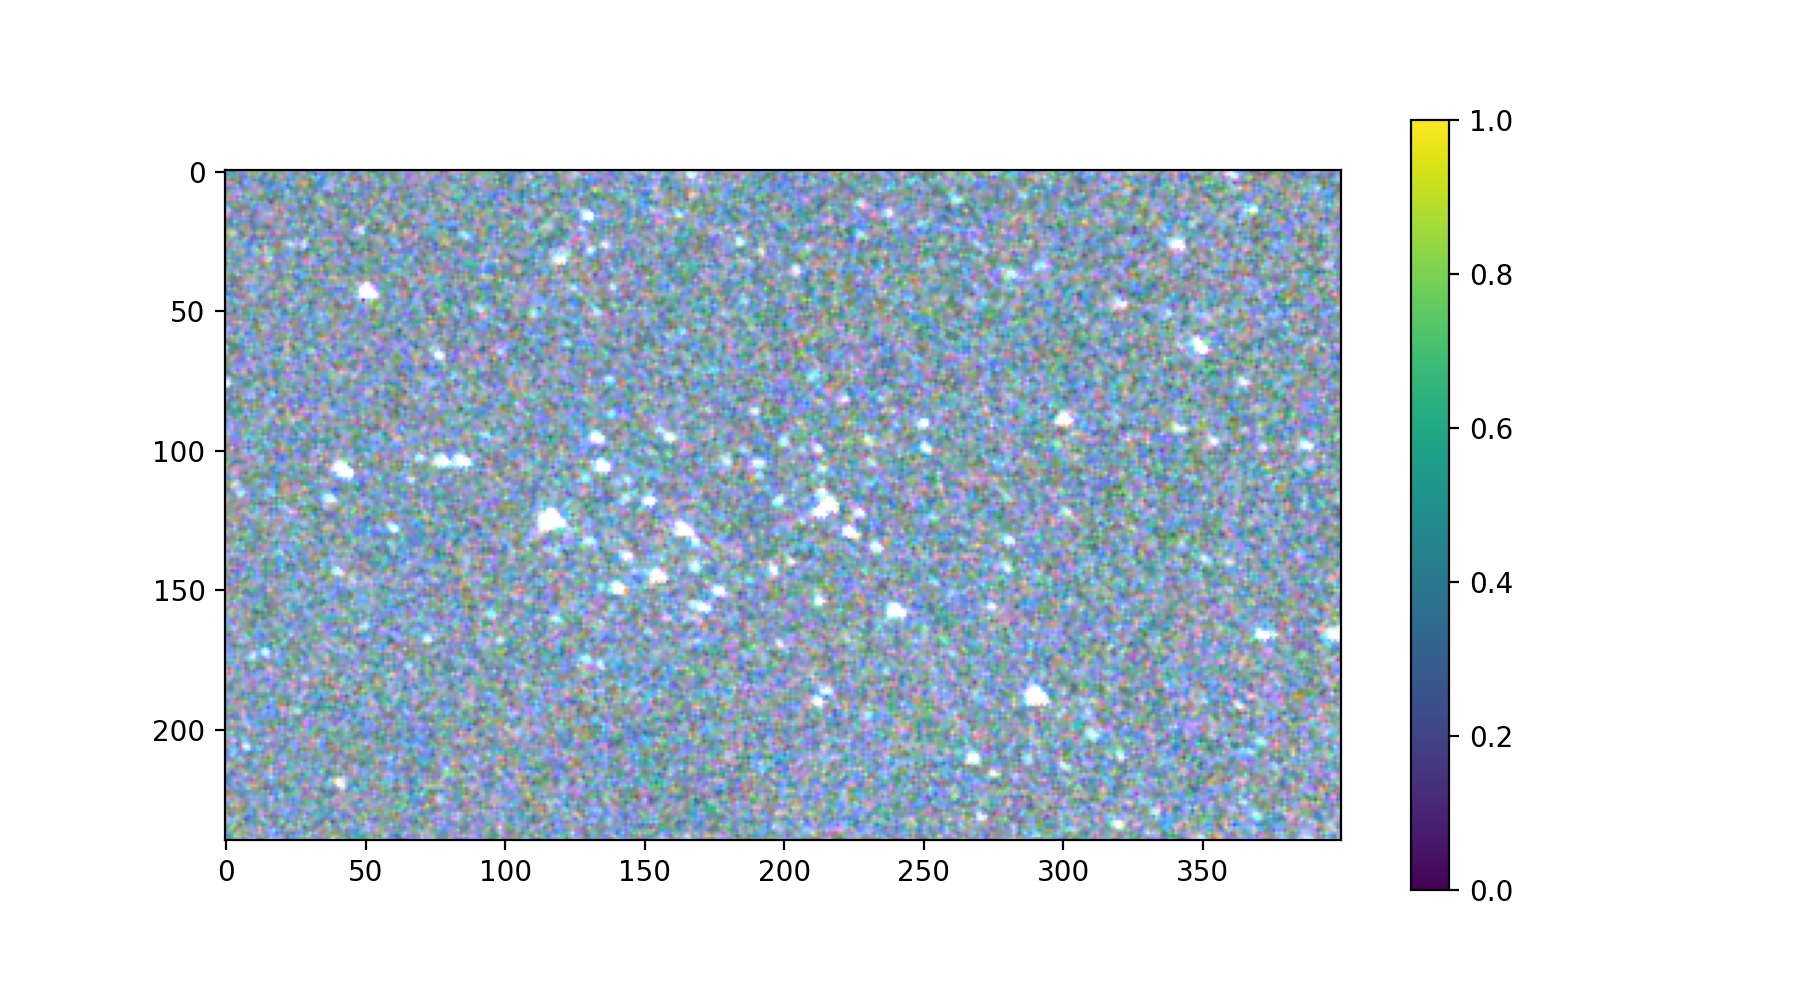

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled[1800:2040,3400:3800])
plt.colorbar()

## Alternatively, combine directly

Instead of debayering, use the raw RGB array directly. Each band needs to be normalized with an appropriate factor that should create, ideally, star images that are well behaved. That is, the different gains associated with each band must be accounted for so star images are smooth peaks.  

In [8]:
# masks that isolate the RGB pixels 
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

In [9]:
# normalize by flat
imarray = np.copy(raw.raw_image_visible)

# masked flats are full of zeroed pixels. Use inverse instead.
flat_red_inv = np.ones_like(flat_red) / flat_red
flat_green_inv = np.ones_like(flat_green) / flat_green
flat_blue_inv = np.ones_like(flat_blue) / flat_blue

raw_norm_1 = imarray * (flat_red_inv * red_mask * 1./1.2) 
raw_norm_2 = raw_norm_1 + imarray * (flat_green_inv * green_mask * 1./1.4)
raw_norm = raw_norm_2 + imarray * (flat_blue_inv * blue_mask * 1./1.3)

The normalization factors above where chosen based on work in the flat analysis notebook, plus the fact that they seem to generate the smoothest result.

<IPython.core.display.Javascript object>


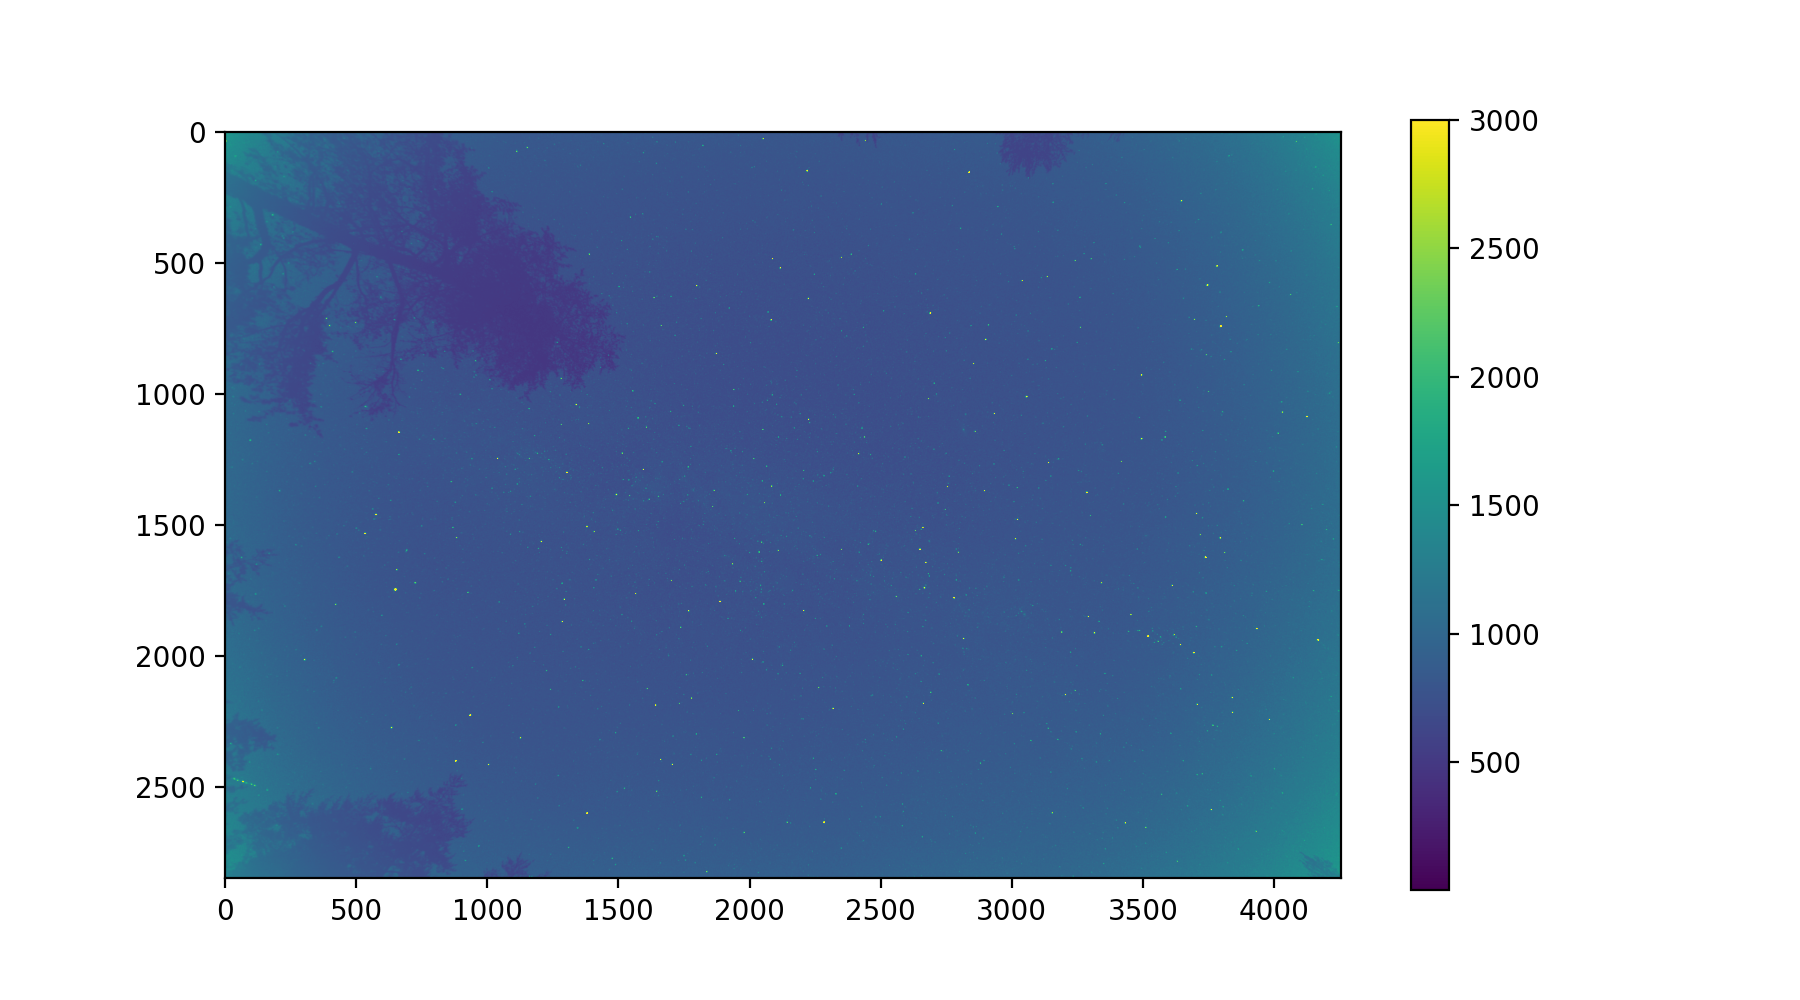

28080.87520966163


In [10]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmax=3000)
plt.colorbar()

<IPython.core.display.Javascript object>


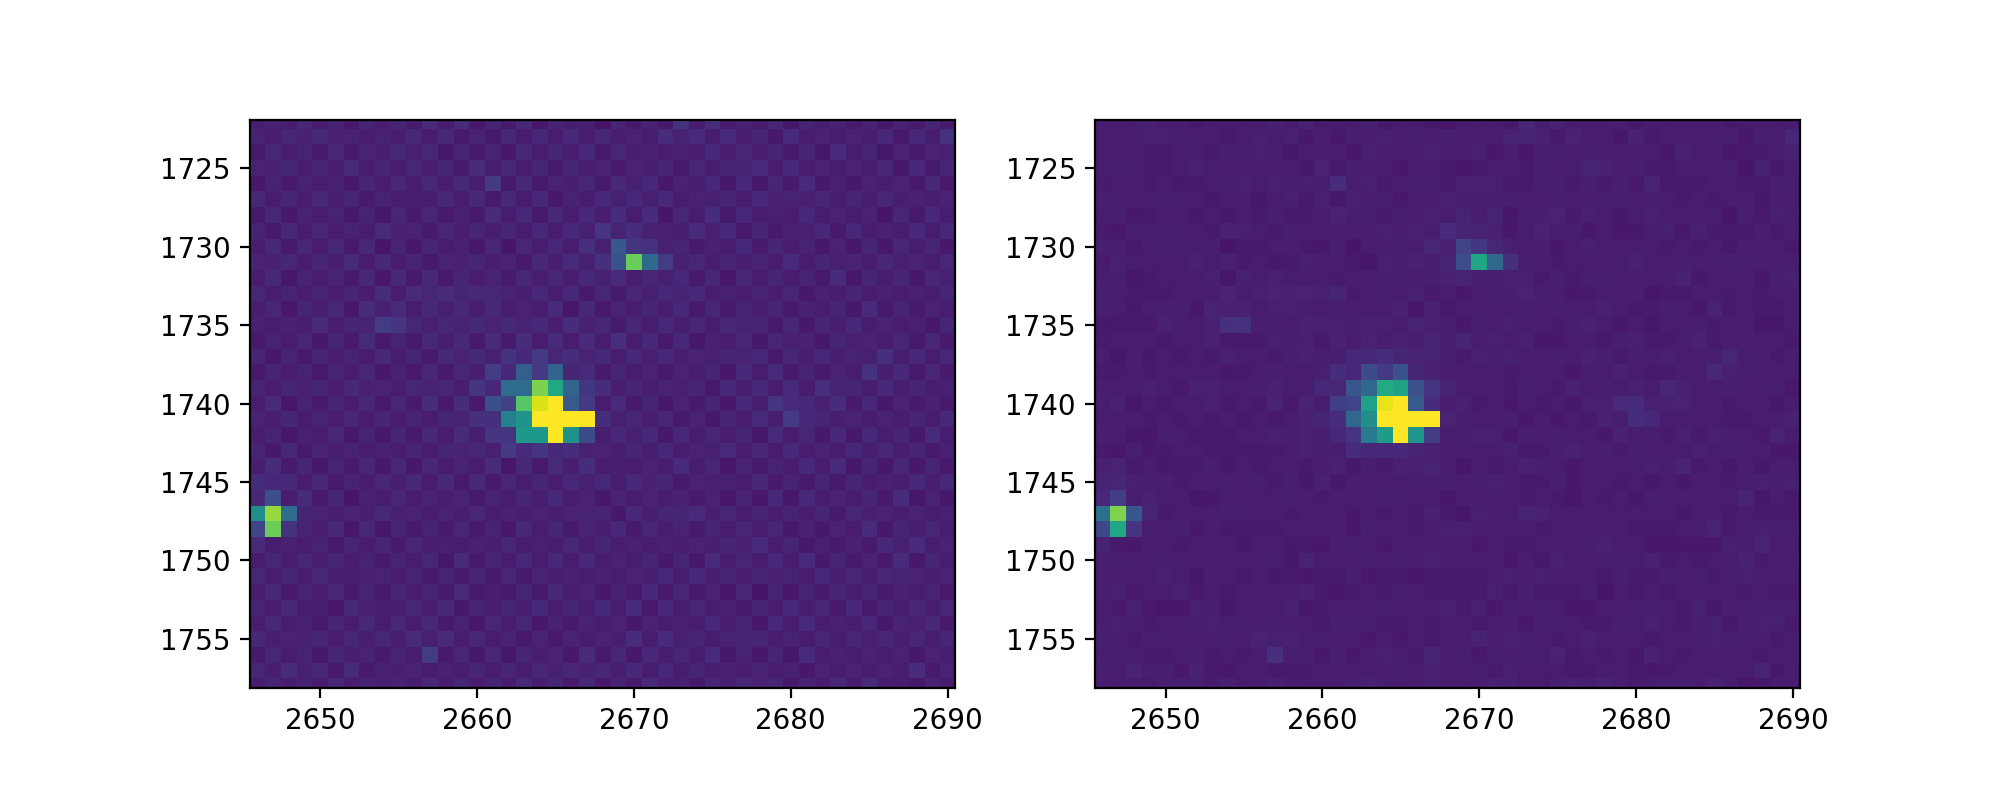

In [11]:
fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 2, 1)
# plt.imshow(imarray[1800:2040,3400:3800], vmax=20000)
plt.imshow(imarray, vmax=10000)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm, vmax=10000)